In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
from darts import TimeSeries
from darts.utils import statistics

In [5]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [6]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [7]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [8]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [9]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [10]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-03-30    583.59
2025-03-31    246.35
2025-04-01    507.40
2025-04-02    608.20
2025-04-03    417.47
Name: daily_policy_index, Length: 8859, dtype: float64

In [11]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [12]:
data_ts = [TimeSeries.from_series(series) for series in data]

# First experiment: Job Listings on Indeed UK

In [13]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [14]:
series = data_ts[0]

In [15]:
splitting = 0.95
visualizing = 0.9

In [16]:
train, val = series.split_before(splitting)

In [17]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

In [18]:
len(series)

1890

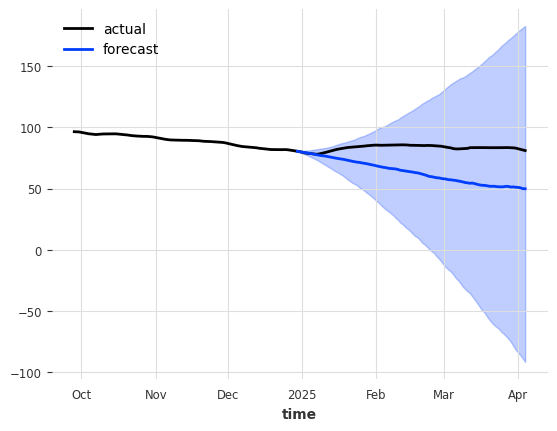

In [19]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [51]:
from darts.models import StatsForecastAutoARIMA

model_aarima = StatsForecastAutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

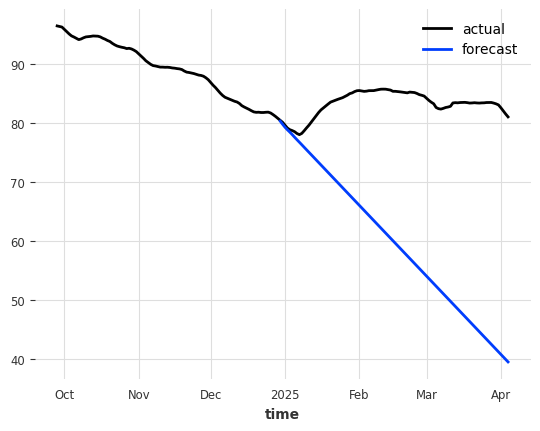

In [52]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction_aarima.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [2]:
horizon = 1
points_to_test = 100

In [54]:
from darts.models import Prophet

models = [ExponentialSmoothing(), AutoARIMA(), Prophet()]
# backtests returns a series containing the last point at each iteration of the forecast horizon that is set
backtests = [model.historical_forecasts(
    series,
    start=len(series) - points_to_test,
    forecast_horizon=horizon,
    verbose=True)
             for model in models]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:14 - cmdstanpy - INFO - Chain [1] done processing
17:26:14 - cmdstanpy - INFO - Chain [1] start processing
17:26:14 - cmdstanpy - INFO - Chain [1] done processing
17:26:14 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing
17:26:15 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing
17:26:15 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1]

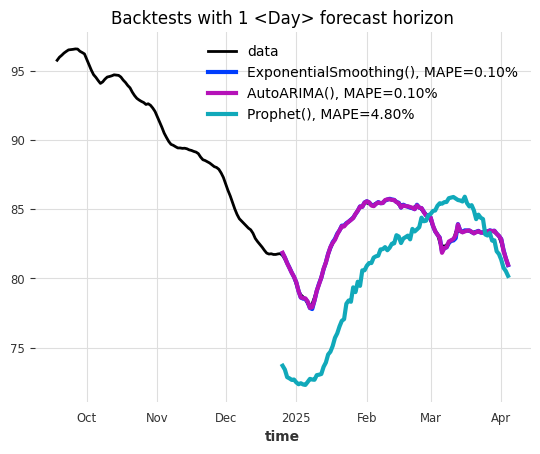

In [55]:
from darts.metrics import mape

series.drop_before(len(series) - 2 * points_to_test).plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
plt.legend()
plt.show()

In [59]:
for model in models:
    model.fit(series)
    model.save(f"{model}.pkl")

In [56]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [57]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

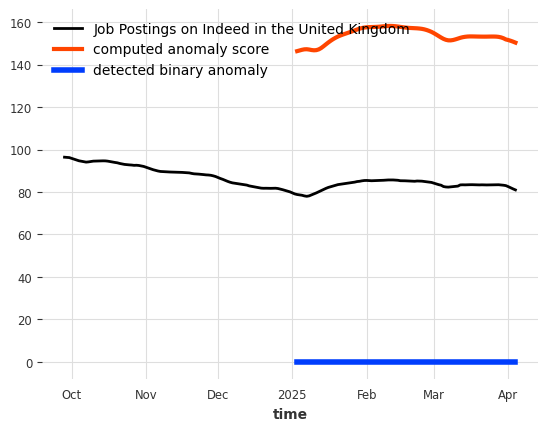

In [58]:
series.drop_before(visualizing).plot()
(anom_score + 1.5 * max(series.drop_before(visualizing))).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * .5 * max(series.drop_before(visualizing))).plot(label="detected binary anomaly", lw=4)
plt.show()